In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [54]:
ls ../../data

arg-kp/                  key_points_our_test.csv   our_test.csv
arg-quality/             key_points_our_valid.csv  our_valid.csv
arguments_our_test.csv   labels_our_test.csv       training_df.csv
arguments_our_valid.csv  labels_our_valid.csv      valid_df.csv


In [ ]:
argument_df = pd.read_csv('../../data/argum')

In [53]:
training_df = pd.read_csv('../../data/training_df.csv')
valid_df = pd.read_csv('../../data/our_valid.csv')

In [3]:
training_df.head()

,Unnamed: 0,arg_id,key_point_id,label,argument,topic,stance,key_point
0,0,arg_0_0,kp_0_0,0,`people reach their limit when it comes to their quality of life and should be able to end their suffering. this can be done with little or no suffering by assistance and the person is able to say good bye.,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
1,1,arg_0_1,kp_0_0,0,"A patient should be able to decide when they have had enough ""care"".",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
2,2,arg_0_2,kp_0_0,0,"a person has the right to end their suffering and if somebody takes pity on them and chooses to help, that person should not be punished.",Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
3,3,arg_0_4,kp_0_0,0,a person should have the right to be able to choose if they want to live or die,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it
4,4,arg_0_5,kp_0_0,0,a person should have the right to die on their own terms,Assisted suicide should be a criminal offence,-1,Assisted suicide gives dignity to the person that wants to commit it


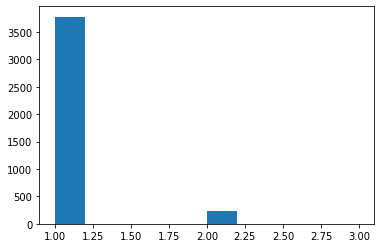

In [117]:
keypoints_per_arg = [x[1] for x in training_df[training_df.label == 1].arg_id.value_counts().to_dict().items()]
plt.hist(keypoints_per_arg)
plt.show()

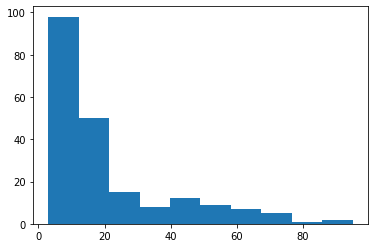

In [118]:
args_per_keypoints = [x[1] for x in training_df[training_df.label == 1].key_point_id.value_counts().to_dict().items()]
plt.hist(args_per_keypoints)
plt.show()

In [ ]:
#Add to the dataframe 0 labels for non-matched argument/keypoint


-------------

### Data Preparation:

In [4]:
import random
import nltk
from nltk.corpus import stopwords

In [56]:
def overlap(t1, t2):
    t1_words = set([w for w in nltk.word_tokenize(t1.lower()) if w not in stopwords.words('english')])
    t2_words = set([w for w in nltk.word_tokenize(t2.lower()) if w not in stopwords.words('english')])
    return len(set(t1_words).intersection(t2_words))/len(t1_words.union(t2_words))

def get_cand_neg(argument, key_points, not_allowed_keypoints, count=3):
    #remove the matching keypoints
    cand_keypoints = [item[1] for item in key_points.items() if item[1] not in not_allowed_keypoints]
    scored_cand_keypoints = sorted([(cp, overlap(cp, argument)) for cp in cand_keypoints], key=lambda x: x[1])
    
    hard_cand_keypoints = scored_cand_keypoints[0:count]
    easy_cand_keypoints = scored_cand_keypoints[-count:]
#     print(argument)
#     print(cand_keypoints[0:10])
#     print('======')
    selected_kp = hard_cand_keypoints + easy_cand_keypoints
    return selected_kp
    
    #return [random.sample(cand_keypoints, count)]

def gen_kp_triplet(labels_df, max_neg_samples=5, sample_extra=False, add_topic=False):
    arguments = pd.Series(labels_df.argument.values, index=labels_df.arg_id).to_dict()
    keypoints= pd.Series(labels_df.key_point.values, index=labels_df.key_point_id).to_dict()

    triplets = []
    for kp_id, keypoint in list(keypoints.items()):
        neg_args = [row['argument'] for idx, row in labels_df[labels_df.key_point_id == kp_id].iterrows() if row['label'] == 0]
        pos_args = [row['argument'] for idx, row in labels_df[labels_df.key_point_id == kp_id].iterrows() if row['label'] == 1]
        
        topic = labels_df[labels_df.key_point_id==kp_id]['topic'].tolist()[0]
        
        if len(pos_args) == 0:
            print('Skipping keypoint with no arguments!')
            continue

        if sample_extra:
            #Add randomly sampled negative key-points
            cand_neg_arguments = get_cand_neg(keypoint, arguments, pos_arguments + neg_arguments)
        
        
        for pos_arg in pos_args:
            #sort the neg_arg
            neg_args = sorted(neg_args, key= lambda x: - overlap(x, pos_arg))
            #sample half hard and half easy neg_args
            neg_args = neg_args[0:max_neg_samples] + neg_args[-max_neg_samples:]

            #first add the gt negative key-point
            if len(neg_args) > 0:
                for neg_arg in neg_args:
                    triplets.append([topic+' <SEP> '+keypoint, pos_arg, neg_arg])
            
            if sample_extra:
                #Add some negative examples
                for cand_neg_arg in cand_neg_arguments:
                    triplets.append([keypoint, pos_arg, cand_neg_arg ])
    
    return triplets

In [58]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=10)
valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1)

training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])

Skipping keypoint with no arguments!


In [59]:
training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor.csv')
valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor.csv')

In [60]:
train_triplets_data = gen_kp_triplet(training_df, max_neg_samples=10, add_topic=True)
valid_triplets_data = gen_kp_triplet(valid_df, max_neg_samples=1, add_topic=True)

training_triplet_kp_as_anchor_df = pd.DataFrame(train_triplets_data, columns=['anchor', 'pos', 'neg'])
valid_triplet_kp_as_anchor_df = pd.DataFrame(valid_triplets_data, columns=['anchor', 'pos', 'neg'])

training_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_kp_as_anchor_topic_added.csv')
valid_triplet_kp_as_anchor_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_kp_as_anchor_topic_added.csv')

Skipping keypoint with no arguments!


#### Creating data for the batch-triplet:

In [53]:
map_labels={x[1]: int(x[0]) for x in enumerate(set(training_df.key_point_id.tolist()))}

In [54]:
pos_df = training_df[training_df.label != 0]
pos_arguments = [(x[0], 'arg', x[1], (map_labels[x[1]]*2)) for x in pos_df[['argument', 'key_point_id']].values.tolist()]

kp_seriese = pd.Series(training_df.key_point_id.values, index= training_df.key_point).to_dict()
key_points    = [(x[0], 'kp', x[1], (map_labels[x[1]]*2)+1) for x in kp_seriese.items()]
all_instances_df = pd.DataFrame(pos_arguments + key_points, columns=['text', 'type', 'kp_id', 'label'])

In [55]:
np.random.shuffle(all_instances_df.values)

In [56]:
all_instances_df.head()

,text,type,kp_id,label
0,assisted suicide allows people who have terrible health conditions to die with dignity. if assisted suicide is a crime they may have to endure many more years living in agony.,arg,kp_0_0,410
1,assisted suicide allows terminally ill people to die with dignity and should not be criminalized,arg,kp_0_0,410
2,assisted suicide allows terminally ill persons to choose when to die and do it with dignity. it lets people decide not to live in a state of pain and misery and choose to pass on with human intervention.,arg,kp_0_0,410
3,assisted suicide gives people control over their life in terrible circumstances. it allows them dignity in death rather than living in terrible conditions for many years.,arg,kp_0_0,410
4,assisted suicide should be allowed because it allows people with terminal illnesses to die with dignity before suffering a long and painful death.,arg,kp_0_0,410


In [57]:
all_instances_df[['text', 'label']].to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/training_df_batch_hard.csv')

In [60]:
#DONT run it because the validation file should be of form argument, pos_keypoint, con_keypoint
# map_labels={x[1]: int(x[0]) for x in enumerate(valid_df.key_point_id.tolist())}
# pos_df = valid_df[valid_df.label != 0]
# pos_arguments = [(x[0], (map_labels[x[1]]*2)+1) for x in pos_df[['argument', 'key_point_id']].values.tolist()]
# key_points    = [(x[0], (map_labels[x[1]]*2)+1) for x in valid_df[['key_point', 'key_point_id']].values.tolist()]

# all_instances_df = pd.DataFrame(pos_arguments + key_points, columns=['text', 'label'])

# all_instances_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_batch_hard.csv')
#valid_triplet_df.to_csv('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/valid_df_batch_hard.csv')

----------

### Training:

In [36]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
%autoreload

import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '7'
sys.path.insert(0, "../src-py")

import sbert_training

#### Training on simple triplets:

In [65]:
sbert_training.train_model('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/',
                           '../../data',
                           'our_valid',
                           '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/',
                           'bert-base-uncased', model_suffix='kp_as_anchor_topic_added', data_file_suffix='kp_as_anchor_topic_added',
                           num_epochs=5, add_special_token=True, train_batch_size=16)

2021-05-24 13:52:17 - Use pytorch device: cuda
2021-05-24 13:52:17 - Read Triplet train dataset


2021-05-24 13:54:39 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 500 steps:
mAP strict= 0.6525086774407545 ; mAP relaxed = 0.8833763402356452
2021-05-24 13:54:41 - mAP strict:   	65.25
2021-05-24 13:54:41 - mAP relaxed:   	88.34
2021-05-24 13:54:41 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11
2021-05-24 13:57:04 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 1000 steps:
mAP strict= 0.7760948021706726 ; mAP relaxed = 0.9150671785222195
2021-05-24 13:57:06 - mAP strict:   	77.61
2021-05-24 13:57:06 - mAP relaxed:   	91.51
2021-05-24 13:57:06 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11
2021-05-24 13:59:28 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 1500 steps:
mAP strict= 0.7370553936484664 ; mAP relaxed = 0.885

2021-05-24 14:20:06 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 500 steps:
mAP strict= 0.813926868774498 ; mAP relaxed = 0.9424348119617398
2021-05-24 14:20:08 - mAP strict:   	81.39
2021-05-24 14:20:08 - mAP relaxed:   	94.24
2021-05-24 14:20:08 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor_topic_added-2021-05-24_13-52-11
2021-05-24 14:22:29 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 1000 steps:
mAP strict= 0.785464232400237 ; mAP relaxed = 0.9305795127482848
2021-05-24 14:22:31 - mAP strict:   	78.55
2021-05-24 14:22:31 - mAP relaxed:   	93.06
2021-05-24 14:24:51 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 1500 steps:
mAP strict= 0.8259432196789906 ; mAP relaxed = 0.9355831901854779
2021-05-24 14:24:53 - mAP strict:   	82.59
2021-05-24 14:24:53 - mAP relaxed:   	93.56
2021-05-24 14:24:53 - Save model to /workspace/ceph_data/keypoint

2021-05-24 14:45:22 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 500 steps:
mAP strict= 0.7539634100062211 ; mAP relaxed = 0.8978257090898848
2021-05-24 14:45:24 - mAP strict:   	75.40
2021-05-24 14:45:24 - mAP relaxed:   	89.78
2021-05-24 14:47:44 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 1000 steps:
mAP strict= 0.7244299442080883 ; mAP relaxed = 0.8708668235002641
2021-05-24 14:47:46 - mAP strict:   	72.44
2021-05-24 14:47:46 - mAP relaxed:   	87.09
2021-05-24 14:50:06 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 1500 steps:
mAP strict= 0.7439922280935364 ; mAP relaxed = 0.9005285132239339
2021-05-24 14:50:08 - mAP strict:   	74.40
2021-05-24 14:50:08 - mAP relaxed:   	90.05
2021-05-24 14:52:28 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 2000 steps:
mAP strict= 0.7390911856316752 ; mAP relaxed = 0.8894154378516844
2021-05-24 14:52:29 - mAP strict:   	73.91
2021-05-24 14

2021-05-24 15:10:33 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 500 steps:
mAP strict= 0.7526969039799162 ; mAP relaxed = 0.913401463946678
2021-05-24 15:10:35 - mAP strict:   	75.27
2021-05-24 15:10:35 - mAP relaxed:   	91.34
2021-05-24 15:12:55 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 1000 steps:
mAP strict= 0.733605330554933 ; mAP relaxed = 0.901143253930593
2021-05-24 15:12:57 - mAP strict:   	73.36
2021-05-24 15:12:57 - mAP relaxed:   	90.11
2021-05-24 15:15:17 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 1500 steps:
mAP strict= 0.747195264352604 ; mAP relaxed = 0.9232803383346073
2021-05-24 15:15:19 - mAP strict:   	74.72
2021-05-24 15:15:19 - mAP relaxed:   	92.33
2021-05-24 15:17:39 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 2000 steps:
mAP strict= 0.8006172818255533 ; mAP relaxed = 0.9391717593917799
2021-05-24 15:17:41 - mAP strict:   	80.06
2021-05-24 15:17:

2021-05-24 15:35:44 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 500 steps:
mAP strict= 0.7827402041298065 ; mAP relaxed = 0.9323579740388318
2021-05-24 15:35:45 - mAP strict:   	78.27
2021-05-24 15:35:45 - mAP relaxed:   	93.24
2021-05-24 15:38:06 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 1000 steps:
mAP strict= 0.7656385940455468 ; mAP relaxed = 0.9263486466550253
2021-05-24 15:38:07 - mAP strict:   	76.56
2021-05-24 15:38:07 - mAP relaxed:   	92.63
2021-05-24 15:40:27 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 1500 steps:
mAP strict= 0.7711084251261706 ; mAP relaxed = 0.9299628374654267
2021-05-24 15:40:29 - mAP strict:   	77.11
2021-05-24 15:40:29 - mAP relaxed:   	93.00
2021-05-24 15:42:49 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 2000 steps:
mAP strict= 0.7580226420088969 ; mAP relaxed = 0.9189880898966981
2021-05-24 15:42:51 - mAP strict:   	75.80
2021-05-24 15

In [ ]:
sbert_training.train_model('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/',
                           '../../data',
                           'our_valid',
                           '/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/',
                           'bert-base-uncased', model_suffix='kp_as_anchor', data_file_suffix='kp_as_anchor',
                           num_epochs=5, add_special_token=False, train_batch_size=16)

2021-05-24 15:58:40 - Use pytorch device: cuda
2021-05-24 15:58:40 - Read Triplet train dataset


2021-05-24 16:01:05 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 500 steps:
mAP strict= 0.6957150637360908 ; mAP relaxed = 0.88475060070072
2021-05-24 16:01:07 - mAP strict:   	69.57
2021-05-24 16:01:07 - mAP relaxed:   	88.48
2021-05-24 16:01:07 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor-2021-05-24_15-58-35
2021-05-24 16:03:31 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 1000 steps:
mAP strict= 0.7408105367274198 ; mAP relaxed = 0.9066931765131134
2021-05-24 16:03:32 - mAP strict:   	74.08
2021-05-24 16:03:32 - mAP relaxed:   	90.67
2021-05-24 16:03:32 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/siamese-models/bert-base-uncased-kp_as_anchor-2021-05-24_15-58-35
2021-05-24 16:05:56 - TripletEvaluator: Evaluating the model on dev dataset in epoch 0 after 1500 steps:
mAP strict= 0.7764079384312422 ; mAP relaxed = 0.8981600294504914
2021-05-24 1

2021-05-24 16:26:45 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 500 steps:
mAP strict= 0.7831499013154375 ; mAP relaxed = 0.8973968215326857
2021-05-24 16:26:47 - mAP strict:   	78.31
2021-05-24 16:26:47 - mAP relaxed:   	89.74
2021-05-24 16:29:07 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 1000 steps:
mAP strict= 0.826656808102099 ; mAP relaxed = 0.9423307274425334
2021-05-24 16:29:09 - mAP strict:   	82.67
2021-05-24 16:29:09 - mAP relaxed:   	94.23
2021-05-24 16:31:31 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 1500 steps:
mAP strict= 0.7594846463194747 ; mAP relaxed = 0.8919999387886378
2021-05-24 16:31:33 - mAP strict:   	75.95
2021-05-24 16:31:33 - mAP relaxed:   	89.20
2021-05-24 16:33:54 - TripletEvaluator: Evaluating the model on dev dataset in epoch 1 after 2000 steps:
mAP strict= 0.8175044228151906 ; mAP relaxed = 0.9345407819023106
2021-05-24 16:33:56 - mAP strict:   	81.75
2021-05-24 16:

2021-05-24 16:52:08 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 500 steps:
mAP strict= 0.755083936410658 ; mAP relaxed = 0.9217472127508177
2021-05-24 16:52:10 - mAP strict:   	75.51
2021-05-24 16:52:10 - mAP relaxed:   	92.17
2021-05-24 16:54:31 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 1000 steps:
mAP strict= 0.7578878676352415 ; mAP relaxed = 0.923946055904084
2021-05-24 16:54:33 - mAP strict:   	75.79
2021-05-24 16:54:33 - mAP relaxed:   	92.39
2021-05-24 16:56:53 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 1500 steps:
mAP strict= 0.7930537079452806 ; mAP relaxed = 0.9239580395192255
2021-05-24 16:56:55 - mAP strict:   	79.31
2021-05-24 16:56:55 - mAP relaxed:   	92.40
2021-05-24 16:59:16 - TripletEvaluator: Evaluating the model on dev dataset in epoch 2 after 2000 steps:
mAP strict= 0.807549743757945 ; mAP relaxed = 0.9199285927500856
2021-05-24 16:59:18 - mAP strict:   	80.75
2021-05-24 16:59

2021-05-24 17:17:29 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 500 steps:
mAP strict= 0.7988080486558804 ; mAP relaxed = 0.9406999461216321
2021-05-24 17:17:31 - mAP strict:   	79.88
2021-05-24 17:17:31 - mAP relaxed:   	94.07
2021-05-24 17:19:52 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 1000 steps:
mAP strict= 0.8048112362240838 ; mAP relaxed = 0.9115288627160275
2021-05-24 17:19:54 - mAP strict:   	80.48
2021-05-24 17:19:54 - mAP relaxed:   	91.15
2021-05-24 17:22:14 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 1500 steps:
mAP strict= 0.7733251448326637 ; mAP relaxed = 0.9266818110665447
2021-05-24 17:22:16 - mAP strict:   	77.33
2021-05-24 17:22:16 - mAP relaxed:   	92.67
2021-05-24 17:24:37 - TripletEvaluator: Evaluating the model on dev dataset in epoch 3 after 2000 steps:
mAP strict= 0.7841401752512731 ; mAP relaxed = 0.9278293799771534
2021-05-24 17:24:39 - mAP strict:   	78.41
2021-05-24 17

2021-05-24 17:42:49 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 500 steps:
mAP strict= 0.8210978779555843 ; mAP relaxed = 0.9397667726374137
2021-05-24 17:42:51 - mAP strict:   	82.11
2021-05-24 17:42:51 - mAP relaxed:   	93.98
2021-05-24 17:45:11 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 1000 steps:
mAP strict= 0.8130176195696459 ; mAP relaxed = 0.9286643929603751
2021-05-24 17:45:13 - mAP strict:   	81.30
2021-05-24 17:45:13 - mAP relaxed:   	92.87
2021-05-24 17:47:34 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 1500 steps:
mAP strict= 0.8170745477775863 ; mAP relaxed = 0.92338295662237
2021-05-24 17:47:36 - mAP strict:   	81.71
2021-05-24 17:47:36 - mAP relaxed:   	92.34
2021-05-24 17:49:57 - TripletEvaluator: Evaluating the model on dev dataset in epoch 4 after 2000 steps:
mAP strict= 0.8295022462047115 ; mAP relaxed = 0.9353016810344664
2021-05-24 17:49:58 - mAP strict:   	82.95
2021-05-24 17:4

### Training Batch Triplet Models:

In [7]:
sbert_training.train_hard_triplet_modle('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/', 
                                        '/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss', 
                                        'bert-base-uncased', training_loss='BatchAllTripletLoss',  
                                        num_epochs=5, train_batch_size=64, data_file_suffix='batch_hard')

2021-05-18 10:29:35 - Read Triplet train dataset
2021-05-18 10:29:35 - Read Triplet dev dataset
2021-05-18 10:29:35 - SentenceLabelDataset: 4467 examples, from which 4260 examples could be used (those labels appeared at least 2 times). 207 different labels found.
2021-05-18 10:29:35 - Load model
2021-05-18 10:29:35 - Load pretrained SentenceTransformer: bert-base-uncased
2021-05-18 10:29:35 - Did not find folder bert-base-uncased
2021-05-18 10:29:35 - Search model on server: http://sbert.net/models/bert-base-uncased.zip
2021-05-18 10:29:35 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-uncased
2021-05-18 10:29:38 - Use pytorch device: cuda
2021-05-18 10:29:38 - Performance before fine-tuning:
2021-05-18 10:29:38 - TripletEvaluator: Evaluating the model on dev dataset:
2021-05-18 10:29:46 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:29:46 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:29:46 - Accuracy Euclidean Dista


2021-05-18 10:30:11 - TripletEvaluator: Evaluating the model on dev dataset after epoch 0:
2021-05-18 10:30:15 - Accuracy Cosine Distance:   	84.80
2021-05-18 10:30:15 - Accuracy Manhatten Distance:	85.30
2021-05-18 10:30:15 - Accuracy Euclidean Distance:	84.80

2021-05-18 10:30:15 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss



2021-05-18 10:30:42 - TripletEvaluator: Evaluating the model on dev dataset after epoch 1:
2021-05-18 10:30:46 - Accuracy Cosine Distance:   	86.10
2021-05-18 10:30:46 - Accuracy Manhatten Distance:	85.60
2021-05-18 10:30:46 - Accuracy Euclidean Distance:	85.20

2021-05-18 10:30:46 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss



2021-05-18 10:31:13 - TripletEvaluator: Evaluating the model on dev dataset after epoch 2:
2021-05-18 10:31:18 - Accuracy Cosine Distance:   	87.00
2021-05-18 10:31:18 - Accuracy Manhatten Distance:	87.30
2021-05-18 10:31:18 - Accuracy Euclidean Distance:	87.50

2021-05-18 10:31:18 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss



2021-05-18 10:31:45 - TripletEvaluator: Evaluating the model on dev dataset after epoch 3:
2021-05-18 10:31:50 - Accuracy Cosine Distance:   	87.80
2021-05-18 10:31:50 - Accuracy Manhatten Distance:	87.30
2021-05-18 10:31:50 - Accuracy Euclidean Distance:	88.10

2021-05-18 10:31:50 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss



2021-05-18 10:32:16 - TripletEvaluator: Evaluating the model on dev dataset after epoch 4:
2021-05-18 10:32:21 - Accuracy Cosine Distance:   	87.60
2021-05-18 10:32:21 - Accuracy Manhatten Distance:	87.80
2021-05-18 10:32:21 - Accuracy Euclidean Distance:	88.30

2021-05-18 10:32:21 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/all-triplet-loss



In [8]:
sbert_training.train_hard_triplet_modle('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/', 
                                        '/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/hard-triplet-loss', 
                                        'bert-base-uncased', training_loss='BatchHardTripletLoss',  
                                        num_epochs=5, train_batch_size=64, data_file_suffix='batch_hard')

2021-05-18 10:32:22 - Read Triplet train dataset
2021-05-18 10:32:22 - Read Triplet dev dataset
2021-05-18 10:32:22 - SentenceLabelDataset: 4467 examples, from which 4260 examples could be used (those labels appeared at least 2 times). 207 different labels found.
2021-05-18 10:32:22 - Load model
2021-05-18 10:32:22 - Load pretrained SentenceTransformer: bert-base-uncased
2021-05-18 10:32:22 - Did not find folder bert-base-uncased
2021-05-18 10:32:22 - Search model on server: http://sbert.net/models/bert-base-uncased.zip
2021-05-18 10:32:22 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-uncased
2021-05-18 10:32:25 - Use pytorch device: cuda
2021-05-18 10:32:25 - Performance before fine-tuning:
2021-05-18 10:32:25 - TripletEvaluator: Evaluating the model on dev dataset:
2021-05-18 10:32:29 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:32:29 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:32:29 - Accuracy Euclidean Dista


2021-05-18 10:32:54 - TripletEvaluator: Evaluating the model on dev dataset after epoch 0:
2021-05-18 10:32:59 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:32:59 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:32:59 - Accuracy Euclidean Distance:	77.70

2021-05-18 10:32:59 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/hard-triplet-loss



2021-05-18 10:33:24 - TripletEvaluator: Evaluating the model on dev dataset after epoch 1:
2021-05-18 10:33:28 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:33:28 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:33:28 - Accuracy Euclidean Distance:	77.70




2021-05-18 10:33:53 - TripletEvaluator: Evaluating the model on dev dataset after epoch 2:
2021-05-18 10:33:58 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:33:58 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:33:58 - Accuracy Euclidean Distance:	77.70




2021-05-18 10:34:22 - TripletEvaluator: Evaluating the model on dev dataset after epoch 3:
2021-05-18 10:34:27 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:34:27 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:34:27 - Accuracy Euclidean Distance:	77.70




2021-05-18 10:34:51 - TripletEvaluator: Evaluating the model on dev dataset after epoch 4:
2021-05-18 10:34:56 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:34:56 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:34:56 - Accuracy Euclidean Distance:	77.70




In [9]:
sbert_training.train_hard_triplet_modle('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/', 
                                        '/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/hard-softmargin-triplet-loss', 
                                        'bert-base-uncased', training_loss='BatchHardSoftMarginTripletLoss',  
                                        num_epochs=5, train_batch_size=64, data_file_suffix='batch_hard')

2021-05-18 10:34:56 - Read Triplet train dataset
2021-05-18 10:34:56 - Read Triplet dev dataset
2021-05-18 10:34:56 - SentenceLabelDataset: 4467 examples, from which 4260 examples could be used (those labels appeared at least 2 times). 207 different labels found.
2021-05-18 10:34:56 - Load model
2021-05-18 10:34:56 - Load pretrained SentenceTransformer: bert-base-uncased
2021-05-18 10:34:56 - Did not find folder bert-base-uncased
2021-05-18 10:34:56 - Search model on server: http://sbert.net/models/bert-base-uncased.zip
2021-05-18 10:34:56 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-uncased
2021-05-18 10:34:59 - Use pytorch device: cuda
2021-05-18 10:34:59 - Performance before fine-tuning:
2021-05-18 10:34:59 - TripletEvaluator: Evaluating the model on dev dataset:
2021-05-18 10:35:04 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:35:04 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:35:04 - Accuracy Euclidean Dista


2021-05-18 10:35:29 - TripletEvaluator: Evaluating the model on dev dataset after epoch 0:
2021-05-18 10:35:33 - Accuracy Cosine Distance:   	82.50
2021-05-18 10:35:33 - Accuracy Manhatten Distance:	78.20
2021-05-18 10:35:33 - Accuracy Euclidean Distance:	77.90

2021-05-18 10:35:33 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/hard-softmargin-triplet-loss



2021-05-18 10:35:59 - TripletEvaluator: Evaluating the model on dev dataset after epoch 1:
2021-05-18 10:36:04 - Accuracy Cosine Distance:   	82.00
2021-05-18 10:36:04 - Accuracy Manhatten Distance:	79.10
2021-05-18 10:36:04 - Accuracy Euclidean Distance:	78.40




2021-05-18 10:36:28 - TripletEvaluator: Evaluating the model on dev dataset after epoch 2:
2021-05-18 10:36:33 - Accuracy Cosine Distance:   	81.90
2021-05-18 10:36:33 - Accuracy Manhatten Distance:	79.30
2021-05-18 10:36:33 - Accuracy Euclidean Distance:	78.80




2021-05-18 10:36:58 - TripletEvaluator: Evaluating the model on dev dataset after epoch 3:
2021-05-18 10:37:02 - Accuracy Cosine Distance:   	81.30
2021-05-18 10:37:02 - Accuracy Manhatten Distance:	79.60
2021-05-18 10:37:02 - Accuracy Euclidean Distance:	78.70




2021-05-18 10:37:27 - TripletEvaluator: Evaluating the model on dev dataset after epoch 4:
2021-05-18 10:37:31 - Accuracy Cosine Distance:   	81.40
2021-05-18 10:37:31 - Accuracy Manhatten Distance:	79.20
2021-05-18 10:37:31 - Accuracy Euclidean Distance:	78.80




In [10]:
sbert_training.train_hard_triplet_modle('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/', 
                                        '/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss', 
                                        'bert-base-uncased', training_loss='BatchSemiHardTripletLoss',  
                                        num_epochs=5, train_batch_size=64, data_file_suffix='batch_hard')

2021-05-18 10:37:31 - Read Triplet train dataset
2021-05-18 10:37:31 - Read Triplet dev dataset
2021-05-18 10:37:31 - SentenceLabelDataset: 4467 examples, from which 4260 examples could be used (those labels appeared at least 2 times). 207 different labels found.
2021-05-18 10:37:31 - Load model
2021-05-18 10:37:31 - Load pretrained SentenceTransformer: bert-base-uncased
2021-05-18 10:37:31 - Did not find folder bert-base-uncased
2021-05-18 10:37:31 - Search model on server: http://sbert.net/models/bert-base-uncased.zip
2021-05-18 10:37:31 - Load SentenceTransformer from folder: /root/.cache/torch/sentence_transformers/sbert.net_models_bert-base-uncased
2021-05-18 10:37:34 - Use pytorch device: cuda
2021-05-18 10:37:34 - Performance before fine-tuning:
2021-05-18 10:37:34 - TripletEvaluator: Evaluating the model on dev dataset:
2021-05-18 10:37:39 - Accuracy Cosine Distance:   	79.70
2021-05-18 10:37:39 - Accuracy Manhatten Distance:	79.50
2021-05-18 10:37:39 - Accuracy Euclidean Dista


2021-05-18 10:38:04 - TripletEvaluator: Evaluating the model on dev dataset after epoch 0:
2021-05-18 10:38:09 - Accuracy Cosine Distance:   	88.10
2021-05-18 10:38:09 - Accuracy Manhatten Distance:	87.20
2021-05-18 10:38:09 - Accuracy Euclidean Distance:	87.60

2021-05-18 10:38:09 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 10:38:35 - TripletEvaluator: Evaluating the model on dev dataset after epoch 1:
2021-05-18 10:38:39 - Accuracy Cosine Distance:   	87.80
2021-05-18 10:38:39 - Accuracy Manhatten Distance:	88.10
2021-05-18 10:38:39 - Accuracy Euclidean Distance:	88.20

2021-05-18 10:38:39 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 10:39:06 - TripletEvaluator: Evaluating the model on dev dataset after epoch 2:
2021-05-18 10:39:11 - Accuracy Cosine Distance:   	91.00
2021-05-18 10:39:11 - Accuracy Manhatten Distance:	90.70
2021-05-18 10:39:11 - Accuracy Euclidean Distance:	90.70

2021-05-18 10:39:11 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 10:39:37 - TripletEvaluator: Evaluating the model on dev dataset after epoch 3:
2021-05-18 10:39:41 - Accuracy Cosine Distance:   	91.60
2021-05-18 10:39:41 - Accuracy Manhatten Distance:	91.40
2021-05-18 10:39:41 - Accuracy Euclidean Distance:	91.50

2021-05-18 10:39:41 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 10:40:08 - TripletEvaluator: Evaluating the model on dev dataset after epoch 4:
2021-05-18 10:40:12 - Accuracy Cosine Distance:   	91.50
2021-05-18 10:40:12 - Accuracy Manhatten Distance:	91.60
2021-05-18 10:40:12 - Accuracy Euclidean Distance:	91.20




In [14]:
sbert_training.train_hard_triplet_modle('/workspace/ceph_data/keypoint-analysis-sharedtask/siamese-data/', 
                                        '/workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss', 
                                        'bert-base-uncased', training_loss='BatchSemiHardTripletLoss',  
                                        num_epochs=10, train_batch_size=64, data_file_suffix='batch_hard')

2021-05-18 11:47:12 - Read Triplet train dataset
2021-05-18 11:47:12 - Read Triplet dev dataset
2021-05-18 11:47:12 - SentenceLabelDataset: 4467 examples, from which 4260 examples could be used (those labels appeared at least 2 times). 207 different labels found.
2021-05-18 11:47:12 - Load model
2021-05-18 11:47:17 - Use pytorch device: cuda
2021-05-18 11:47:17 - Performance before fine-tuning:
2021-05-18 11:47:17 - TripletEvaluator: Evaluating the model on dev dataset:
2021-05-18 11:47:22 - Accuracy Cosine Distance:   	79.70
2021-05-18 11:47:22 - Accuracy Manhatten Distance:	79.50
2021-05-18 11:47:22 - Accuracy Euclidean Distance:	77.70




2021-05-18 11:47:47 - TripletEvaluator: Evaluating the model on dev dataset after epoch 0:
2021-05-18 11:47:51 - Accuracy Cosine Distance:   	87.10
2021-05-18 11:47:51 - Accuracy Manhatten Distance:	86.40
2021-05-18 11:47:51 - Accuracy Euclidean Distance:	87.20

2021-05-18 11:47:51 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 11:48:17 - TripletEvaluator: Evaluating the model on dev dataset after epoch 1:
2021-05-18 11:48:21 - Accuracy Cosine Distance:   	87.70
2021-05-18 11:48:21 - Accuracy Manhatten Distance:	87.10
2021-05-18 11:48:21 - Accuracy Euclidean Distance:	87.50

2021-05-18 11:48:21 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 11:48:47 - TripletEvaluator: Evaluating the model on dev dataset after epoch 2:
2021-05-18 11:48:51 - Accuracy Cosine Distance:   	88.40
2021-05-18 11:48:51 - Accuracy Manhatten Distance:	88.30
2021-05-18 11:48:51 - Accuracy Euclidean Distance:	88.30

2021-05-18 11:48:51 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 11:49:17 - TripletEvaluator: Evaluating the model on dev dataset after epoch 3:
2021-05-18 11:49:21 - Accuracy Cosine Distance:   	89.50
2021-05-18 11:49:21 - Accuracy Manhatten Distance:	90.10
2021-05-18 11:49:21 - Accuracy Euclidean Distance:	89.20

2021-05-18 11:49:21 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 11:49:47 - TripletEvaluator: Evaluating the model on dev dataset after epoch 4:
2021-05-18 11:49:52 - Accuracy Cosine Distance:   	89.60
2021-05-18 11:49:52 - Accuracy Manhatten Distance:	90.00
2021-05-18 11:49:52 - Accuracy Euclidean Distance:	89.60




2021-05-18 11:50:16 - TripletEvaluator: Evaluating the model on dev dataset after epoch 5:
2021-05-18 11:50:21 - Accuracy Cosine Distance:   	90.70
2021-05-18 11:50:21 - Accuracy Manhatten Distance:	90.60
2021-05-18 11:50:21 - Accuracy Euclidean Distance:	90.20

2021-05-18 11:50:21 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 11:50:47 - TripletEvaluator: Evaluating the model on dev dataset after epoch 6:
2021-05-18 11:50:52 - Accuracy Cosine Distance:   	90.40
2021-05-18 11:50:52 - Accuracy Manhatten Distance:	90.80
2021-05-18 11:50:52 - Accuracy Euclidean Distance:	90.20

2021-05-18 11:50:52 - Save model to /workspace/ceph_data/keypoint-analysis-sharedtask/triplet-models/semi-hard-triplet-loss



2021-05-18 11:51:18 - TripletEvaluator: Evaluating the model on dev dataset after epoch 7:
2021-05-18 11:51:22 - Accuracy Cosine Distance:   	89.60
2021-05-18 11:51:22 - Accuracy Manhatten Distance:	89.80
2021-05-18 11:51:22 - Accuracy Euclidean Distance:	89.50




2021-05-18 11:51:47 - TripletEvaluator: Evaluating the model on dev dataset after epoch 8:
2021-05-18 11:51:52 - Accuracy Cosine Distance:   	89.90
2021-05-18 11:51:52 - Accuracy Manhatten Distance:	90.40
2021-05-18 11:51:52 - Accuracy Euclidean Distance:	90.00




2021-05-18 11:52:17 - TripletEvaluator: Evaluating the model on dev dataset after epoch 9:
2021-05-18 11:52:21 - Accuracy Cosine Distance:   	90.80
2021-05-18 11:52:21 - Accuracy Manhatten Distance:	90.60
2021-05-18 11:52:21 - Accuracy Euclidean Distance:	90.80




------------